# Import packages

In [1]:
# Import the packages 
from model_lib import *
from model_builder import *
from external_function_lib import *
from packages_lib import *
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
%matplotlib inline
from multiprocessing import Queue
import pickle
import cv2
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Flatten,Dropout,Dense,ELU, Lambda, Activation
from keras.layers import SpatialDropout2D,Cropping2D,Convolution2D,MaxPooling2D
from sklearn.utils import shuffle
from keras.regularizers import l2
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
#from keras.utils import plot_model
from IPython.display import SVG
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import gaussian_filter
import glob
print ("Packages loaded")

Using TensorFlow backend.


Packages Loaded!
Packages loaded


# Build the sekeleton estimation model

In [2]:
weights_path = "data/model_weights.h5" 
model_skeleton = generate_pose_detection_model(6)
model_skeleton.load_weights(weights_path)

# Build the gesture claasification model

In [3]:
#scalerfile = 'scaler.sav'
#scaler = pickle.load(open(scalerfile, 'rb'))
model_gesture = load_model('gesture_predict.h5')

# Load and visualize the testing image

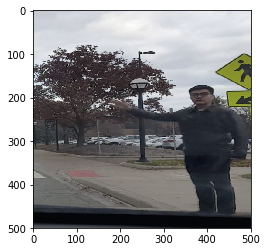

In [77]:
test_image_path = "sample_test/test13.jpg"
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (500,500))
plt.imshow(test_img[:,:,[2,1,0]])

# Run the skeleton estimation model

In [78]:
test_img_copy = test_img
test_img_copy = np.transpose(np.float32(test_img_copy[:,:,:,np.newaxis]), (3,0,1,2)) 
outs = model_skeleton.predict(test_img_copy)
heatmap = np.squeeze(outs[1]) 
heatmap = cv2.resize(heatmap, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
heatmap = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]), interpolation=cv2.INTER_CUBIC)
skeleton = find_key_points(heatmap)

In [79]:
skeleton

[[(385, 202, 0.92006677, 0)],
 [(398, 239, 0.81797892, 1)],
 [(355, 238, 0.68868607, 2)],
 [(294, 244, 0.57955813, 3)],
 [(224, 228, 0.76249444, 4)],
 [(441, 239, 0.67181653, 5)],
 [(480, 290, 0.53233993, 6)],
 [(467, 336, 0.31037664, 7), (466, 337, 0.30914763, 8)],
 [(376, 360, 0.3986502, 9)],
 [(401, 441, 0.41873696, 10)],
 [(254, 339, 0.26195771, 11)],
 [(428, 361, 0.39997128, 12)],
 [(442, 434, 0.37752685, 13)],
 [(254, 340, 0.23986325, 14)],
 [(377, 196, 0.87368906, 15)],
 [(395, 194, 0.90152431, 16)],
 [(368, 203, 0.23043942, 17)],
 [(414, 201, 0.79911518, 18)]]

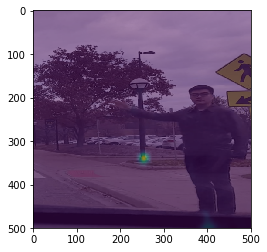

In [80]:
plt.figure()
plt.imshow(test_img[:,:,[2,1,0]])
plt.imshow(heatmap[:,:,10],alpha=.5)

# Visualize the skeleton

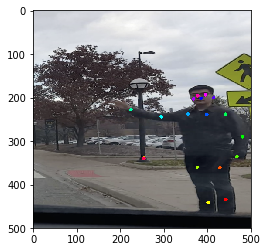

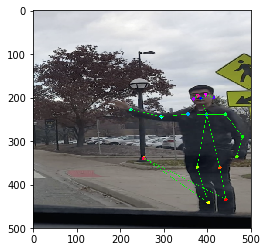

In [81]:
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
img_In = cv2.imread(test_image_path)
img_In = cv2.resize(img_In, (500,500))
plt.figure()
for i in range(18):
    cv2.circle(img_In, skeleton[i][0][0:2], 4, colors[i], thickness=-1)
plt.imshow(img_In[:,:,[2,1,0]])
plt.figure()
line_seg = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]
for i in range(len(line_seg)):
    cv2.line(img_In, skeleton[line_seg[i][0]][0][0:2], skeleton[line_seg[i][1]][0][0:2], (0,255,0), 1) 

plt.imshow(img_In[:,:,[2,1,0]])

# Construct the feature vector

In [82]:
raw_feature = []
for i in range(18):
    raw_feature.append(skeleton[i][0][0])
    raw_feature.append(skeleton[i][0][1])
raw_feature = np.array(raw_feature).reshape((1,36))

In [83]:
X_test = raw_feature[:,[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]
y_test = 1
norm_vec_test = X_test
norm_vec_test = np.zeros((X_test.shape[0],12))
for i in range(X_test.shape[0]):
    for j in range(3):
        norm_vec_test[i,2*j]=(X_test[i,2*j+2]-X_test[i,2*j])/((X_test[i,2*j+2]-X_test[i,2*j])**2+(X_test[i,2*j+3]-X_test[i,2*j+1])**2)**0.5
        norm_vec_test[i,2*j+1]=(X_test[i,2*j+3]-X_test[i,2*j+1])/((X_test[i,2*j+2]-X_test[i,2*j])**2+(X_test[i,2*j+3]-X_test[i,2*j+1])**2)**0.5
    norm_vec_test[i,6] = (X_test[i,8]-X_test[i,0])/((X_test[i,8]-X_test[i,0])**2+(X_test[i,9]-X_test[i,1])**2)**0.5
    norm_vec_test[i,7] = (X_test[i,9]-X_test[i,1])/((X_test[i,8]-X_test[i,0])**2+(X_test[i,9]-X_test[i,1])**2)**0.5
    for j in range(2):
        norm_vec_test[i,8+2*j]=(X_test[i,2*j+10]-X_test[i,2*j+8])/((X_test[i,2*j+10]-X_test[i,2*j+8])**2+(X_test[i,2*j+11]-X_test[i,2*j+9])**2)**0.5
        norm_vec_test[i,9+2*j]=(X_test[i,2*j+11]-X_test[i,2*j+9])/((X_test[i,2*j+10]-X_test[i,2*j+8])**2+(X_test[i,2*j+11]-X_test[i,2*j+9])**2)**0.5 

# Predict the gesture based on key points

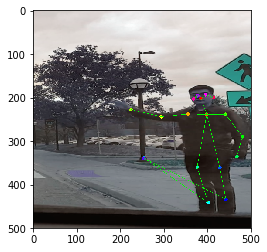

The intention of the human is: Stopping the vehicle
The probability of Stopping the vehicle is 0.009351156651973724
The probability of lane changing is 0.0028388542123138905
The probability of calling taxi is 0.9878100156784058


In [84]:
X_test_normed = norm_vec_test
plt.figure()
plt.imshow(img_In)
test_image_x = X_test_normed[0, :]
test_image_y = 1
X_test_cus = []
X_test_cus.append(np.reshape(test_image_x,(12,1,1)))
X_test_cus = np.array(X_test_cus)
proba = model_gesture.predict(X_test_cus,batch_size = 1)
plt.show()
if test_image_y == 1:
    print ("The intention of the human is: Stopping the vehicle")
if test_image_y == 2:
    print ("The intention of the human is: Calling taxi")
if test_image_y == 2:
    print ("The intention of the human is: Lane changing")
print("The probability of Stopping the vehicle is {}".format(proba[0,1]))
print("The probability of lane changing is {}".format(proba[0,0]))
print("The probability of calling taxi is {}".format(proba[0,2]))